In [ ]:
print("PRATHAM RAJ")

PRATHAM RAJ


Step 1: Data Cleaning & Preparation
Salary Standardization: 200 records cleaned & converted to Annual USD.
Skill Normalization: Top 10 binary features created.

 Step 2: Exploratory Analysis

Mean and Median Salary by Skill (Top 5):
                 Skill  Mean Salary (USD)  Median Salary (USD)
0                 Sql            76283.0              75300.0
1         forecasting            74942.0              75000.0
2    Machine Learning            73472.0              75000.0
3  financial modeling            73459.0              75000.0
4              python            72965.0              75000.0

Top 3 Earning Skill Combinations:
                   Skill Combination  Mean Salary (USD)  Count
0         python + Machine Learning            79723.0     22
1  forecasting + financial modeling            73900.0     20
2                 sql + forecasting            72800.0     20

 Step 3: Statistical Modelling
R-squared (R²): -0.3216

Top 5 Features by Positive Salary Weightage:
        

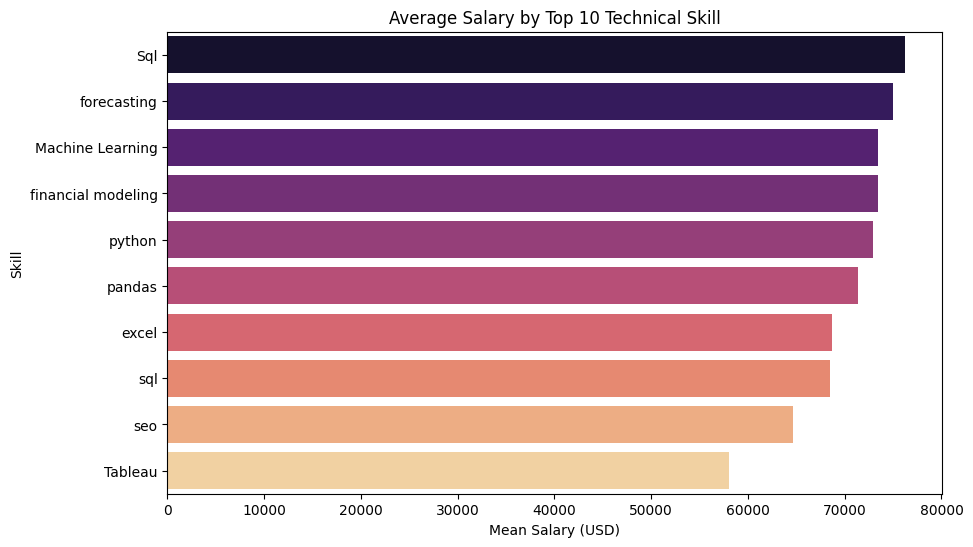

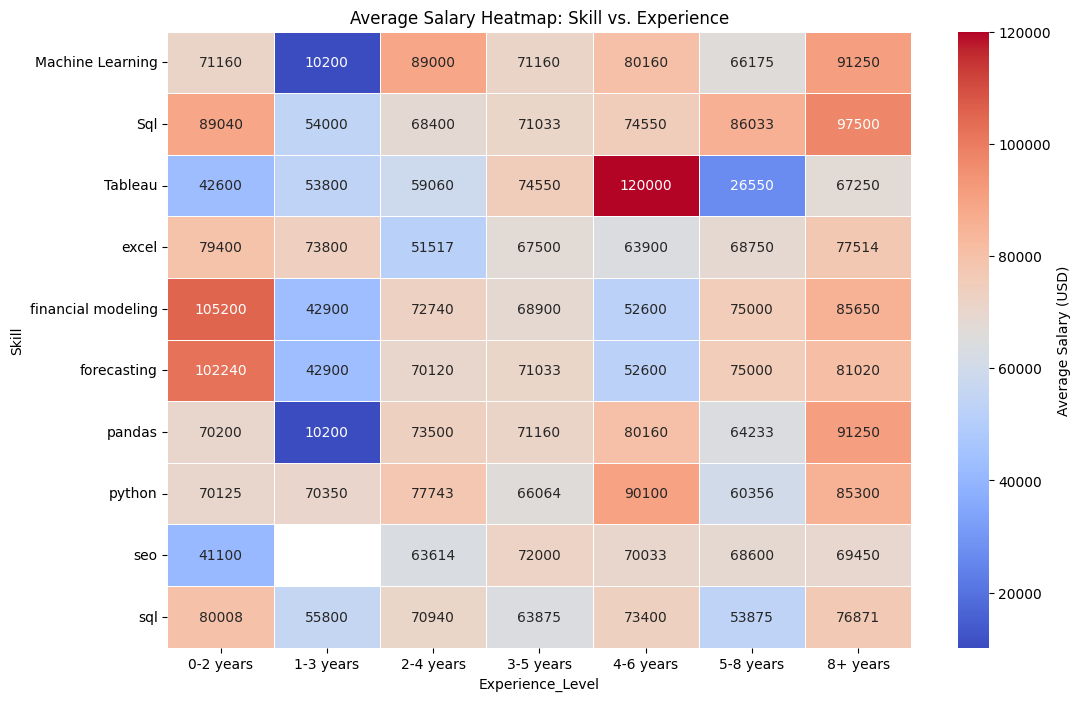

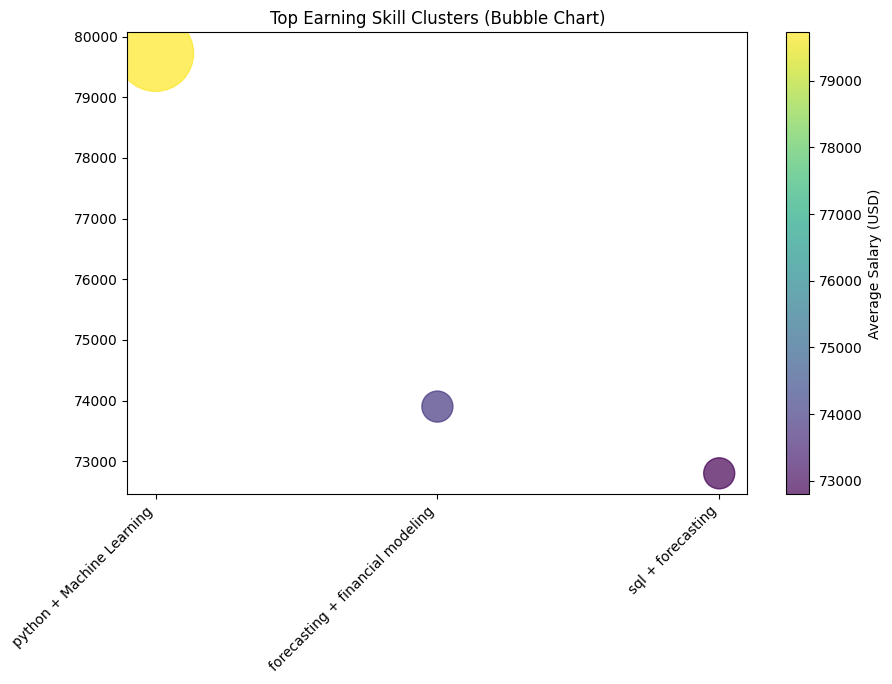


--- Clear Takeaways ---

Top 5 Skills by Average Salary:
1. Sql (Avg. Salary: $76283)
2. forecasting (Avg. Salary: $74942)
3. Machine Learning (Avg. Salary: $73472)
4. financial modeling (Avg. Salary: $73459)
5. python (Avg. Salary: $72965)

 Step 5: Career Recommendations

Interpretation: Professionals mastering **python and Machine Learning** command approximately **37% higher salaries** compared to the lowest-paying skill group observed.

Actionable Upskilling Recommendations:
1.Climb the Experience Ladder:TheLevelbracket is the strongest predictor of high pay (coefficient: $7562).
2.Master the High-Weight Skill:Based on the model, mastering **pythonoffers the highest independent salary weightage.
3.Strategic Industry Alignment: The **Technology industry provides the highest baseline salary premium.


In [ ]:
import pandas as pd
import numpy as np
import re
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations

# --- Configuration & Constants ---
INR_TO_USD_RATE, GBP_TO_USD_RATE, EUR_TO_USD_RATE = 0.012, 1.25, 1.08
SEED = 42
FILEPATH = "/content/job_postings_200_varied.xlsx"
MIN_SAMPLES_FOR_COMBO = 20

NORMALIZATION_MAP = {
    'python 3.0': 'Python', 'pyhton': 'Python', 'py': 'Python', 'sql server': 'SQL', 'mysql': 'SQL',
    'tableau': 'Tableau', 'tablo': 'Tableau', 'aws': 'AWS', 'amazon web services': 'AWS',
    'spark': 'Spark', 'apache spark': 'Spark', 'machine learning': 'Machine Learning',
    'ml': 'Machine Learning', 'tensorflow': 'Machine Learning', 'keras': 'Machine Learning',
}

# 1. Salary Cleaning Helper (Must remain a separate function due to complex conversion logic)
def clean_salary(row):
    """Converts raw salary to annualized USD."""
    nums = re.findall(r'[\d,]+', str(row['Salary_Raw']).replace(' ', ''))
    nums = [float(n.replace(',', '')) for n in nums]
    if not nums: return np.nan

    avg_salary = sum(nums) / len(nums)
    salary_usd = avg_salary

    if '₹' in str(row['Salary_Raw']) or 'INR' in str(row['Salary_Raw']):
        salary_usd *= INR_TO_USD_RATE
    elif '£' in str(row['Salary_Raw']) or 'GBP' in str(row['Salary_Raw']):
        salary_usd *= GBP_TO_USD_RATE
    elif '€' in str(row['Salary_Raw']) or 'EUR' in str(row['Salary_Raw']):
        salary_usd *= EUR_TO_USD_RATE

    if 'Monthly' in row['Salary_Type']:
        salary_usd *= 12

    return round(salary_usd, 0)

if __name__ == '__main__':

    print("Step 1: Data Cleaning & Preparation")
    try:
        df = pd.read_excel(FILEPATH, header=None) # Changed to read_excel
        df.columns = ['Job_Title', 'Skills_Text', 'Experience_Level', 'Salary_Raw', 'Salary_Type', 'Industry', 'Country']
    except FileNotFoundError:
        print(f"Error: File {FILEPATH} not found.")
        exit()

    df = df.dropna(subset=['Skills_Text', 'Salary_Raw', 'Experience_Level']).reset_index(drop=True)
    df['Salary_USD_Cleaned'] = df.apply(clean_salary, axis=1)
    df = df.dropna(subset=['Salary_USD_Cleaned'])
    print(f"Salary Standardization: {len(df)} records cleaned & converted to Annual USD.")
    df['Normalized_Skills'] = df['Skills_Text'].apply(
        lambda x: [NORMALIZATION_MAP.get(re.sub(r'[^a-z0-9]', '', s.strip().lower()), s.capitalize())
                   for s in (x.split(',') if pd.notna(x) else []) if re.sub(r'[^a-z0-9]', '', s.strip().lower())]
    )
    all_skills = [s.strip() for sublist in df['Normalized_Skills'] for s in sublist] # Added strip()
    top_skills = pd.Series(all_skills).value_counts().head(10).index.tolist()
    for skill in top_skills:
        df[f'Skill_{skill}'] = df['Normalized_Skills'].apply(lambda x: 1 if skill in [s.strip() for s in x] else 0) # Added strip()
    print(f"Skill Normalization: Top 10 binary features created.")
    df = df[['Experience_Level', 'Industry', 'Salary_USD_Cleaned'] + [f'Skill_{s}' for s in top_skills]]
    print("\n Step 2: Exploratory Analysis")
    skill_salaries = []
    for skill in top_skills:
        temp_df = df[df[f'Skill_{skill}'] == 1]['Salary_USD_Cleaned']
        if not temp_df.empty:
            skill_salaries.append({'Skill': skill, 'Mean Salary (USD)': round(temp_df.mean(), 0), 'Median Salary (USD)': round(temp_df.median(), 0)})
    salary_by_skill = pd.DataFrame(skill_salaries).sort_values('Mean Salary (USD)', ascending=False).reset_index(drop=True)
    print("\nMean and Median Salary by Skill (Top 5):\n", salary_by_skill.head())
    pair_salaries = []
    for s1, s2 in combinations(top_skills, 2):
        combo_df = df[(df[f'Skill_{s1}'] == 1) & (df[f'Skill_{s2}'] == 1)]
        if len(combo_df) >= MIN_SAMPLES_FOR_COMBO:
            pair_salaries.append({'Skill Combination': f'{s1} + {s2}', 'Mean Salary (USD)': round(combo_df['Salary_USD_Cleaned'].mean(), 0), 'Count': len(combo_df)})
    top_combinations = pd.DataFrame(pair_salaries).sort_values('Mean Salary (USD)', ascending=False).head(3).reset_index(drop=True)
    print(f"\nTop 3 Earning Skill Combinations:\n", top_combinations)
    print("\n Step 3: Statistical Modelling")

    Y, cat_f, num_f = df['Salary_USD_Cleaned'], ['Experience_Level', 'Industry'], [f'Skill_{s}' for s in top_skills]
    X = df[cat_f + num_f]

    preprocessor = ColumnTransformer([('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_f), ('skills', 'passthrough', num_f)], remainder='drop')
    model_pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('regressor', LinearRegression())])
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=SEED)
    model_pipeline.fit(X_train, Y_train)
    r_squared = round(model_pipeline.score(X_test, Y_test), 4)
    print(f"R-squared (R²): {r_squared}")

    f_names = list(model_pipeline['preprocessor'].named_transformers_['cat'].get_feature_names_out(cat_f)) + num_f
    feat_imp = pd.DataFrame({'Feature': f_names, 'Coefficient (Salary Impact)': model_pipeline['regressor'].coef_})
    top_pos_feat = feat_imp[feat_imp['Coefficient (Salary Impact)'] > 0].sort_values('Coefficient (Salary Impact)', ascending=False).head(5)
    print("\nTop 5 Features by Positive Salary Weightage:\n", top_pos_feat)
    print("\n Step 4: Visualization & Insights")
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Mean Salary (USD)', y='Skill', data=salary_by_skill, palette='magma', hue='Skill', legend=False).set_title('Average Salary by Top 10 Technical Skill') # Added hue and legend
    plt.show()
    h_df = pd.DataFrame()
    for skill in top_skills:
        temp = df[df[f'Skill_{skill}'] == 1].groupby('Experience_Level')['Salary_USD_Cleaned'].mean().reset_index()
        temp['Skill'] = skill
        h_df = pd.concat([h_df, temp])
    h_pivot = h_df.pivot_table(index='Skill', columns='Experience_Level', values='Salary_USD_Cleaned', aggfunc='mean')
    plt.figure(figsize=(12, 8))
    sns.heatmap(h_pivot, annot=True, fmt=".0f", cmap='coolwarm', linewidths=.5, cbar_kws={'label': 'Average Salary (USD)'}).set_title('Average Salary Heatmap: Skill vs. Experience')
    plt.show()
    if not top_combinations.empty:
        b_df = top_combinations.copy()
        min_size, max_size = 500, 3000
        b_df['Size'] = (b_df['Count'] - b_df['Count'].min()) / (b_df['Count'].max() - b_df['Count'].min())
        b_df['Size'] = b_df['Size'] * (max_size - min_size) + min_size
        plt.figure(figsize=(10, 6))
        plt.scatter(b_df['Skill Combination'], b_df['Mean Salary (USD)'], s=b_df['Size'], alpha=0.7, c=b_df['Mean Salary (USD)'], cmap='viridis')
        plt.title('Top Earning Skill Clusters (Bubble Chart)')
        plt.xticks(rotation=45, ha='right')
        plt.colorbar(label='Average Salary (USD)')
        plt.show()
    print("\n--- Clear Takeaways ---")
    top_5_s_df = salary_by_skill.head(5)
    print(f"\nTop 5 Skills by Average Salary:")
    for index, row in top_5_s_df.iterrows():
        print(f"{index+1}. {row['Skill']} (Avg. Salary: ${row['Mean Salary (USD)']:.0f})")
    print("\n Step 5: Career Recommendations")

    if not top_combinations.empty:
        top_combo = top_combinations.iloc[0]
        percent_increase = ((top_combo['Mean Salary (USD)'] - salary_by_skill['Mean Salary (USD)'].min()) / salary_by_skill['Mean Salary (USD)'].min()) * 100
        print(f"\nInterpretation: Professionals mastering **{top_combo['Skill Combination'].replace(' + ', ' and ')}** command approximately **{percent_increase:.0f}% higher salaries** compared to the lowest-paying skill group observed.")
    sen_row = top_pos_feat[top_pos_feat['Feature'].str.contains('Experience_')].head(1)
    ind_row = top_pos_feat[top_pos_feat['Feature'].str.contains('Industry_')].head(1)
    skl_row = top_pos_feat[top_pos_feat['Feature'].str.contains('Skill_')].head(1)

    print("\nActionable Upskilling Recommendations:")

    if not sen_row.empty:
        print(f"1.Climb the Experience Ladder:The{sen_row['Feature'].str.split('_').str[1].iloc[0]}bracket is the strongest predictor of high pay (coefficient: ${sen_row['Coefficient (Salary Impact)'].iloc[0]:.0f}).")
    if not skl_row.empty:
        print(f"2.Master the High-Weight Skill:Based on the model, mastering **{skl_row['Feature'].str.split('_').str[1].iloc[0]}offers the highest independent salary weightage.")
    if not ind_row.empty:
        print(f"3.Strategic Industry Alignment: The **{ind_row['Feature'].str.split('_').str[1].iloc[0]} industry provides the highest baseline salary premium.")